# Importing Required Libraries
First, we need to import all the libraries that we will use in this analysis. Matplotlib and seaborn are used for visualization. Scipy is used for statistical analysis. Numpy and pandas are used for data manipulation.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import norm, sem
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Prepping data

In [15]:
df = pd.read_csv("eik.csv", sep=";", decimal=",")

i=7
j=5
k=3

to_delete = [k + 1, 
             j + 1, 
             i+ 1, 
             j*k + 1, 
             i*j + 1, 
             i*k + 1, 
             #i*j*k + 1, not in the set
             i+j+k + 1 ]

df = df.drop(to_delete)

# Data Transformation
We apply log and square root transformations to the 'Volume' and 'Grootte' columns and create new columns for each transformation. We keep the original data for comparison.

In [16]:
transformations = {'Log': np.log, 'Square root': np.sqrt}

for name, function in transformations.items():
    df[name + '_Volume'] = function(df['Volume'])
    df[name + '_Grootte'] = function(df['Grootte'])
    df[name + '_Hoogte'] = function(df['Hoogte'])

# Data Visualization
We will plot histograms and boxplots for original and transformed 'Volume' and 'Grootte' columns.


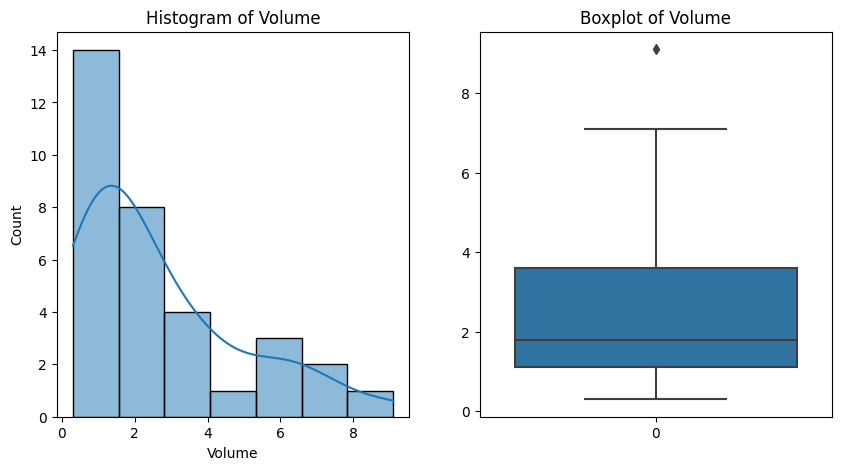

count    33.000000
mean      2.639394
std       2.258033
min       0.300000
25%       1.100000
50%       1.800000
75%       3.600000
max       9.100000
Name: Volume, dtype: float64


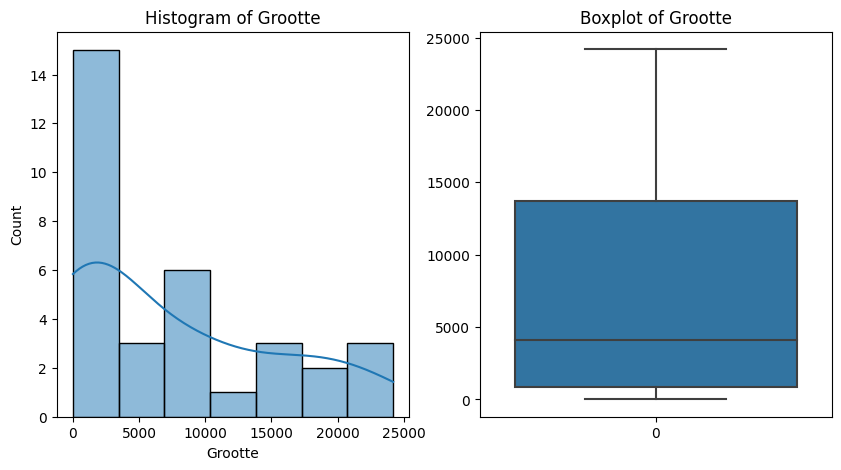

count       33.000000
mean      7568.181818
std       7852.979822
min         13.000000
25%        826.000000
50%       4082.000000
75%      13688.000000
max      24196.000000
Name: Grootte, dtype: float64


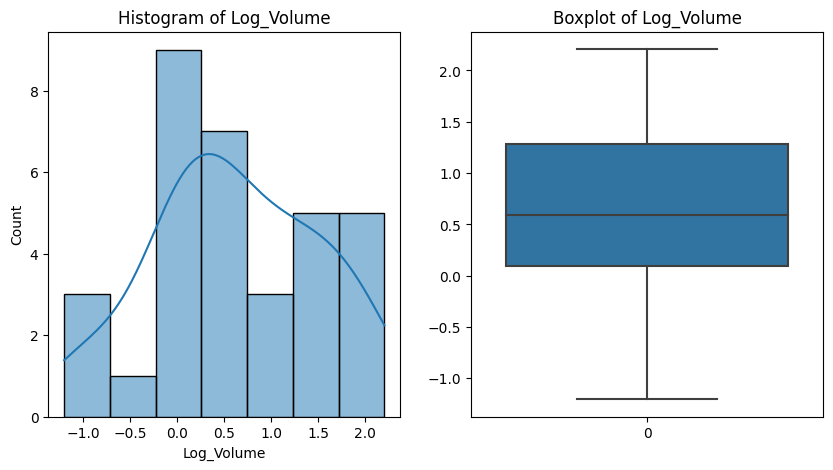

count    33.000000
mean      0.615983
std       0.884560
min      -1.203973
25%       0.095310
50%       0.587787
75%       1.280934
max       2.208274
Name: Log_Volume, dtype: float64


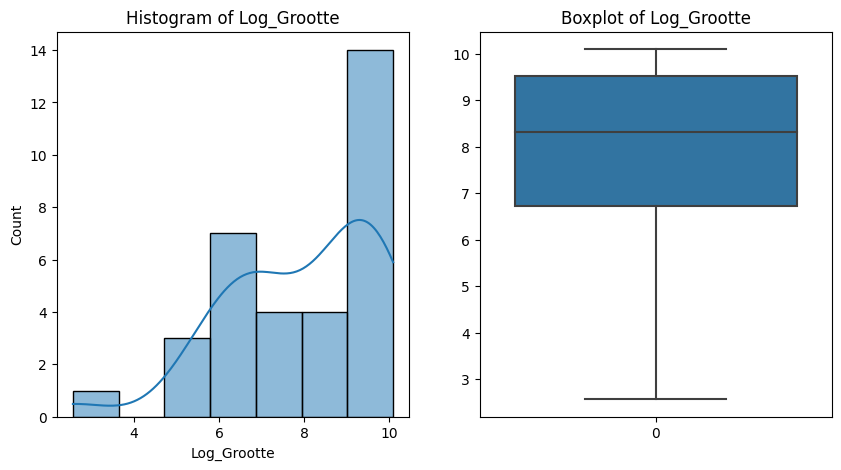

count    33.000000
mean      7.960667
std       1.801473
min       2.564949
25%       6.716595
50%       8.314342
75%       9.524275
max      10.093943
Name: Log_Grootte, dtype: float64


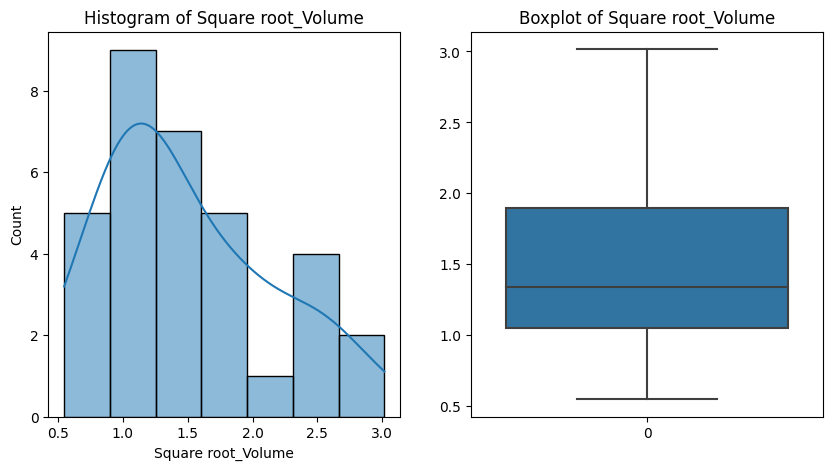

count    33.000000
mean      1.492776
std       0.651045
min       0.547723
25%       1.048809
50%       1.341641
75%       1.897367
max       3.016621
Name: Square root_Volume, dtype: float64


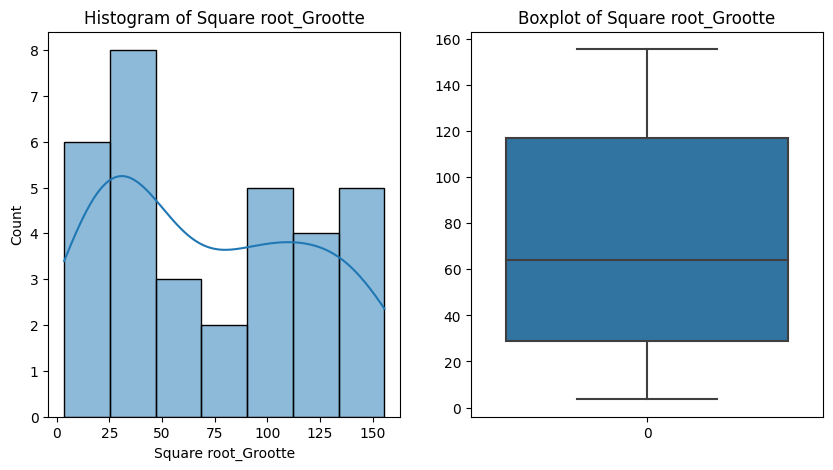

count     33.000000
mean      72.734765
std       48.466670
min        3.605551
25%       28.740216
50%       63.890531
75%      116.995726
max      155.550635
Name: Square root_Grootte, dtype: float64


In [12]:
cols = ['Volume', 'Grootte'] + [f'{name}_{col}' for name in transformations for col in ['Volume', 'Grootte']]

for col in cols:
    plot_hist_boxplot(df, col)

# QQ Plot
We perform QQ plots to visually assess the normality of original and transformed data.

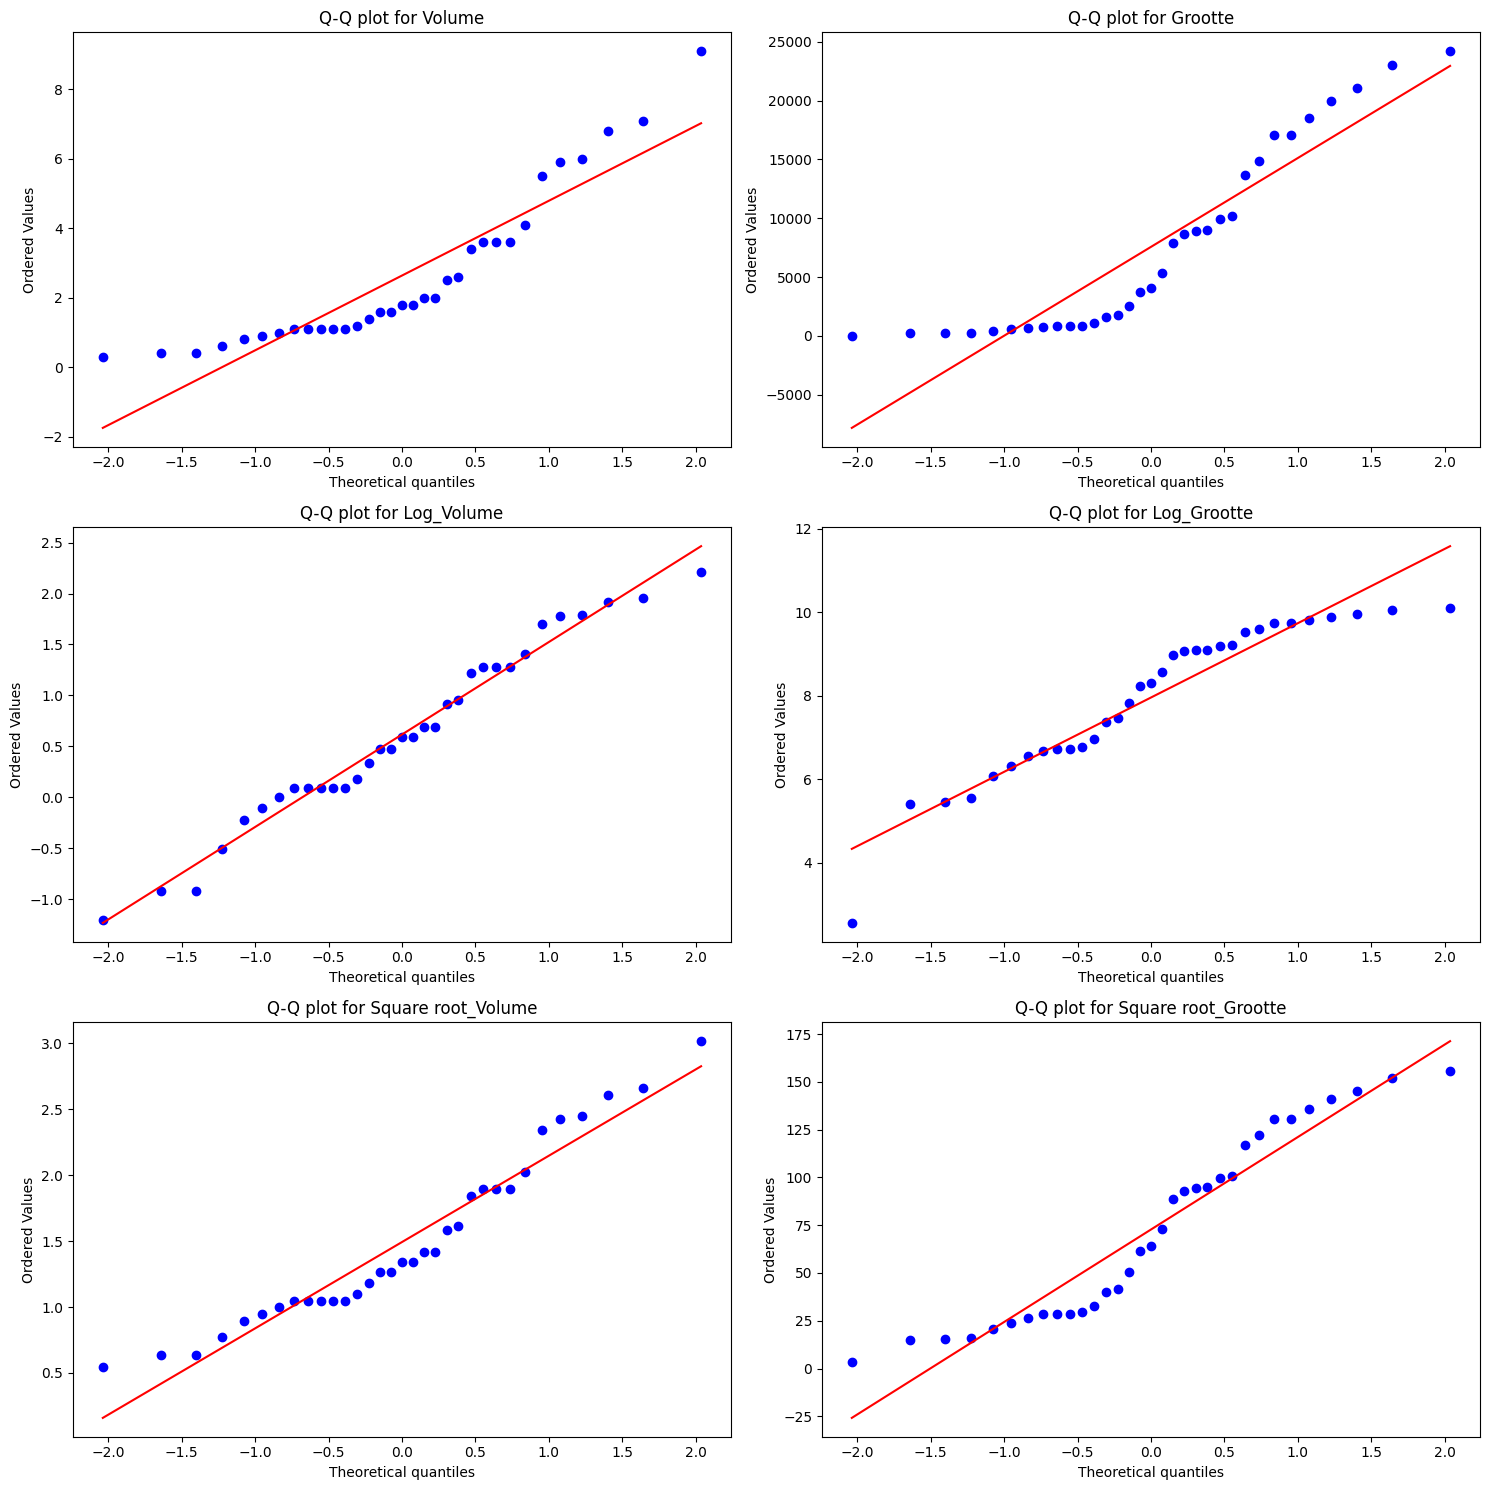

In [20]:
def qq_plot_grid(df, cols):
    # Number of plots
    n = len(cols)
    
    # Define number of rows and columns for plot grid 
    rows = 3
    cols_count = 2
    
    # Create a figure and a grid of subplots
    fig, ax = plt.subplots(rows, cols_count, figsize=(15, 15))

    # Counter
    count = 0

    for row in range(rows):
        for col in range(cols_count):
            if count < n:  # To prevent an empty plot in case of less number of plots
                data = df[cols[count]].dropna()
                stats.probplot(data, dist="norm", plot=ax[row, col])
                ax[row, col].set_title(f"Q-Q plot for {cols[count]}")
                count += 1

    # Remove empty plots
    if count < rows * cols_count:
        for idx in range(count, rows * cols_count):
            fig.delaxes(ax.flatten()[idx])

    # Display the plot
    plt.tight_layout()
    plt.show()

cols = ['Volume', 'Grootte'] + [f'{name}_{col}' for name in transformations for col in ['Volume', 'Grootte']]

qq_plot_grid(df, cols)

# Normality Test
Finally, we will perform the Shapiro-Wilk test on the original and transformed data to test the normality. The null hypothesis is that the data is normally distributed. If the p-value is less than 0.05, we reject the null hypothesis and conclude that the data is not normally distributed.


In [21]:
def normality_test(df, col):
    # original data
    stat, p = stats.shapiro(df[col].dropna())
    print(f'{col}:')
    print(f"\tW-statistic: {stat}, p-value: {p}")
    if p > 0.05:
        print("\tFail to reject the null hypothesis, the data seems to be normally distributed.")
    else:
        print("\tReject the null hypothesis, the data does not seem to be normally distributed.")

for col in cols:
    normality_test(df, col)

Volume:
	W-statistic: 0.8431628346443176, p-value: 0.00024161198234651238
	Reject the null hypothesis, the data does not seem to be normally distributed.
Grootte:
	W-statistic: 0.8444139957427979, p-value: 0.00025711848866194487
	Reject the null hypothesis, the data does not seem to be normally distributed.
Log_Volume:
	W-statistic: 0.9719041585922241, p-value: 0.5345546007156372
	Fail to reject the null hypothesis, the data seems to be normally distributed.
Log_Grootte:
	W-statistic: 0.9056379795074463, p-value: 0.007484225556254387
	Reject the null hypothesis, the data does not seem to be normally distributed.
Square root_Volume:
	W-statistic: 0.9330432415008545, p-value: 0.04275839403271675
	Reject the null hypothesis, the data does not seem to be normally distributed.
Square root_Grootte:
	W-statistic: 0.9091149568557739, p-value: 0.009260003454983234
	Reject the null hypothesis, the data does not seem to be normally distributed.


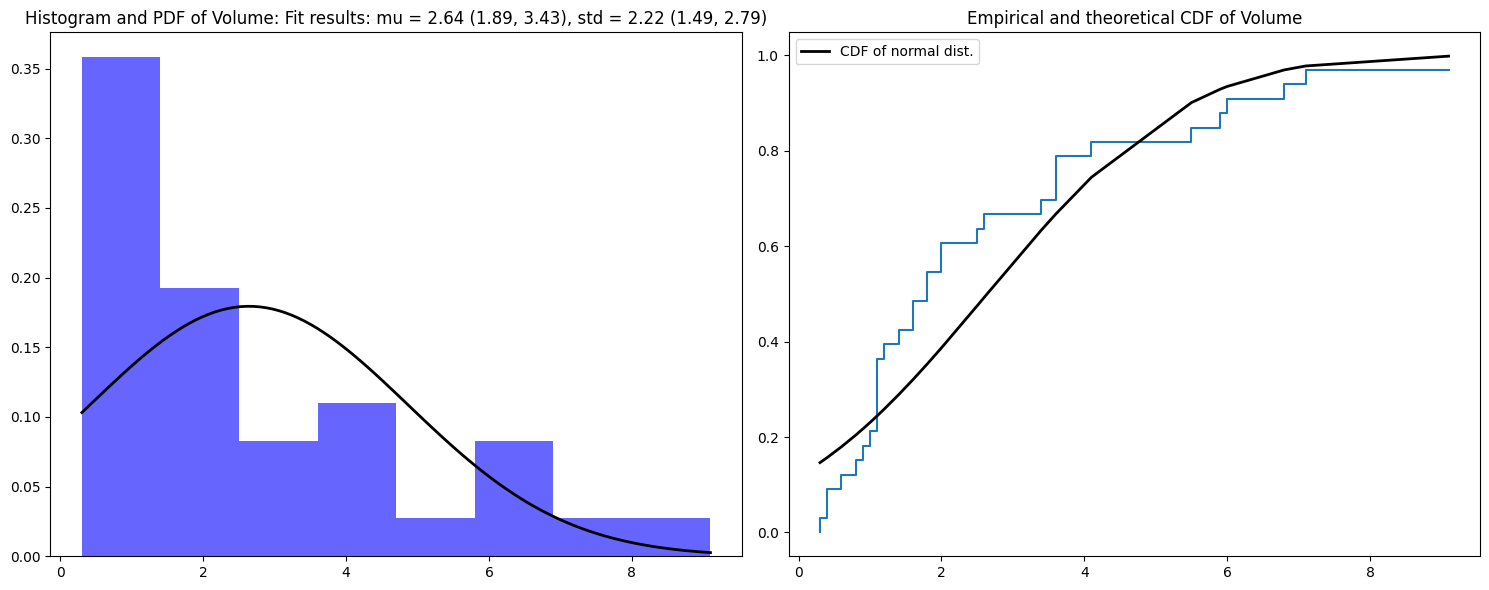

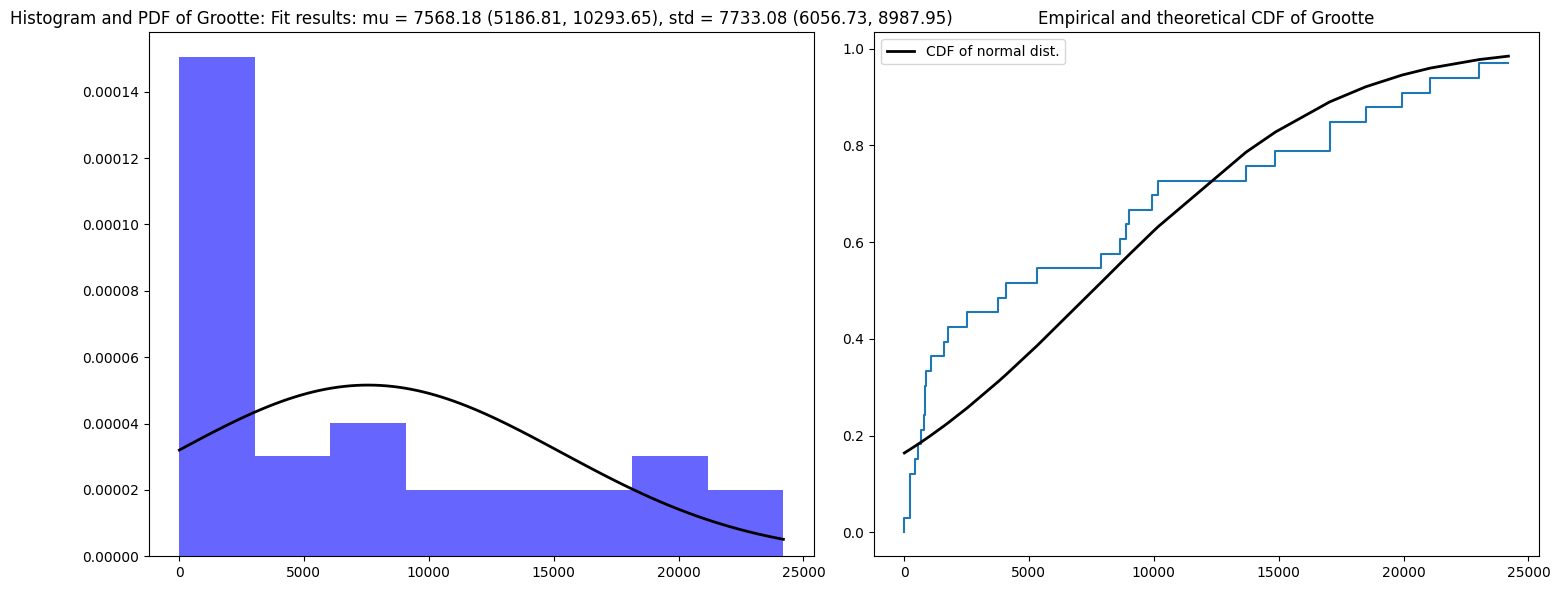

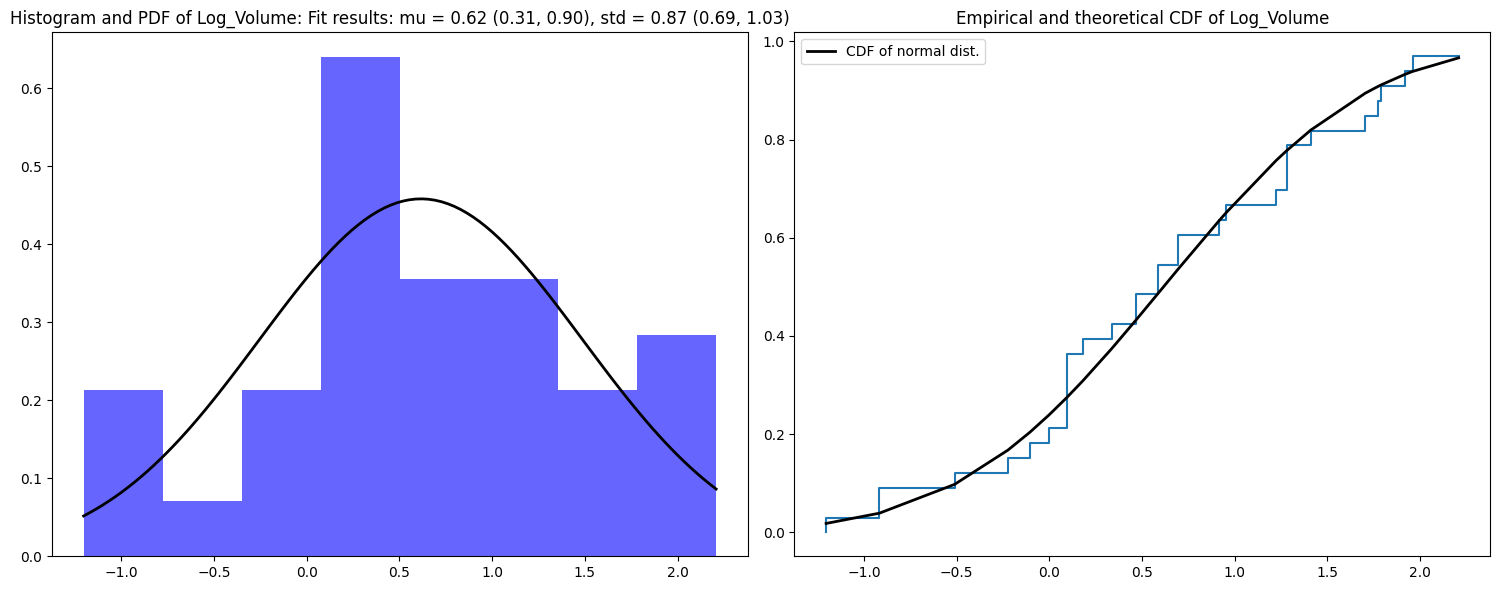

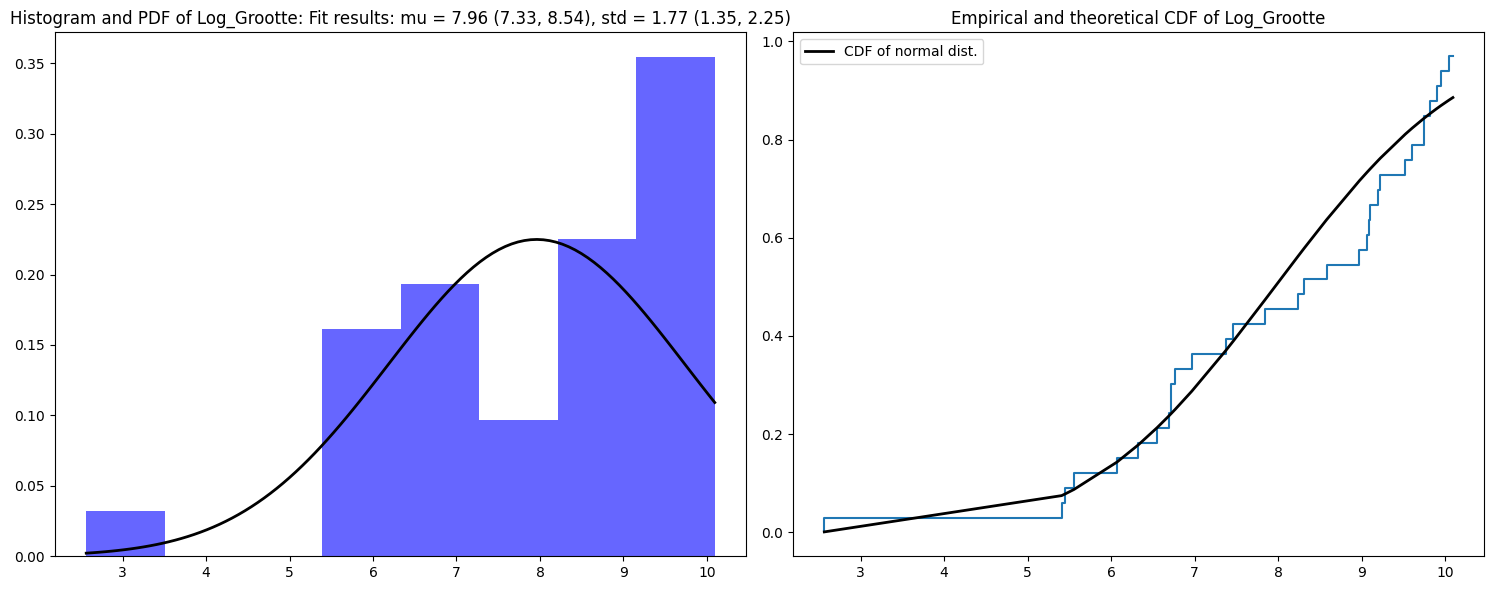

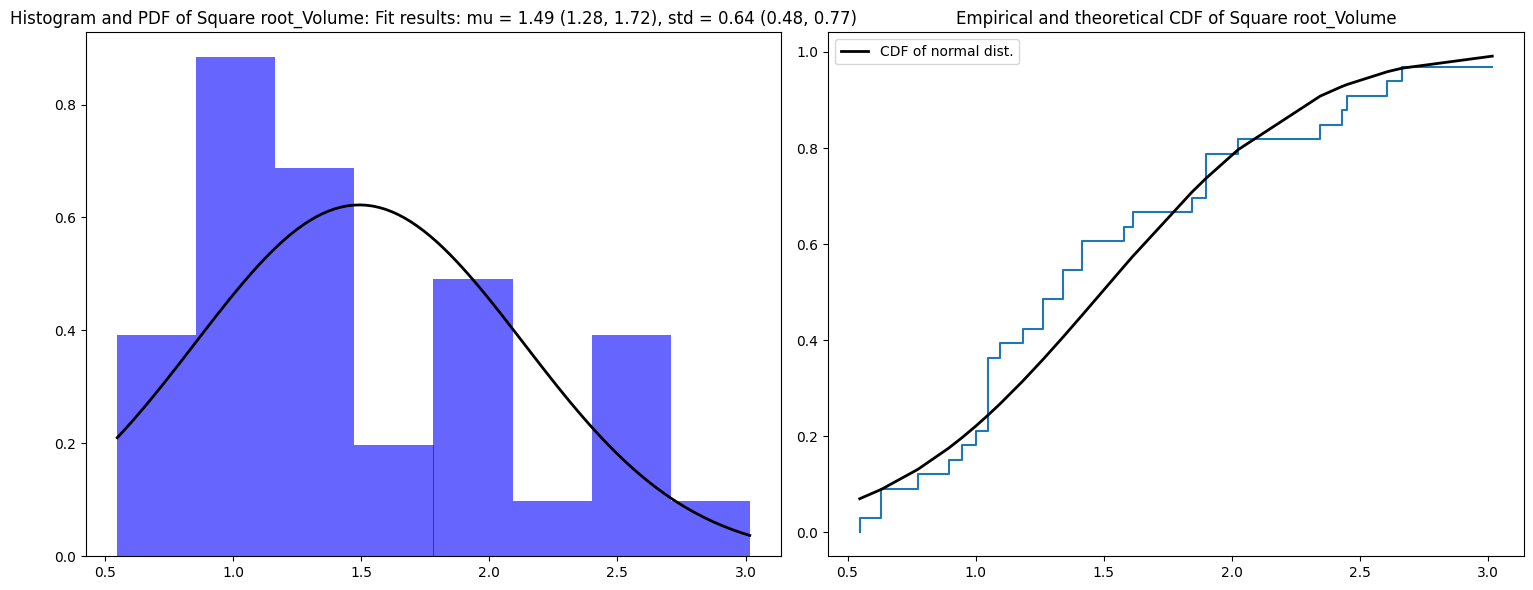

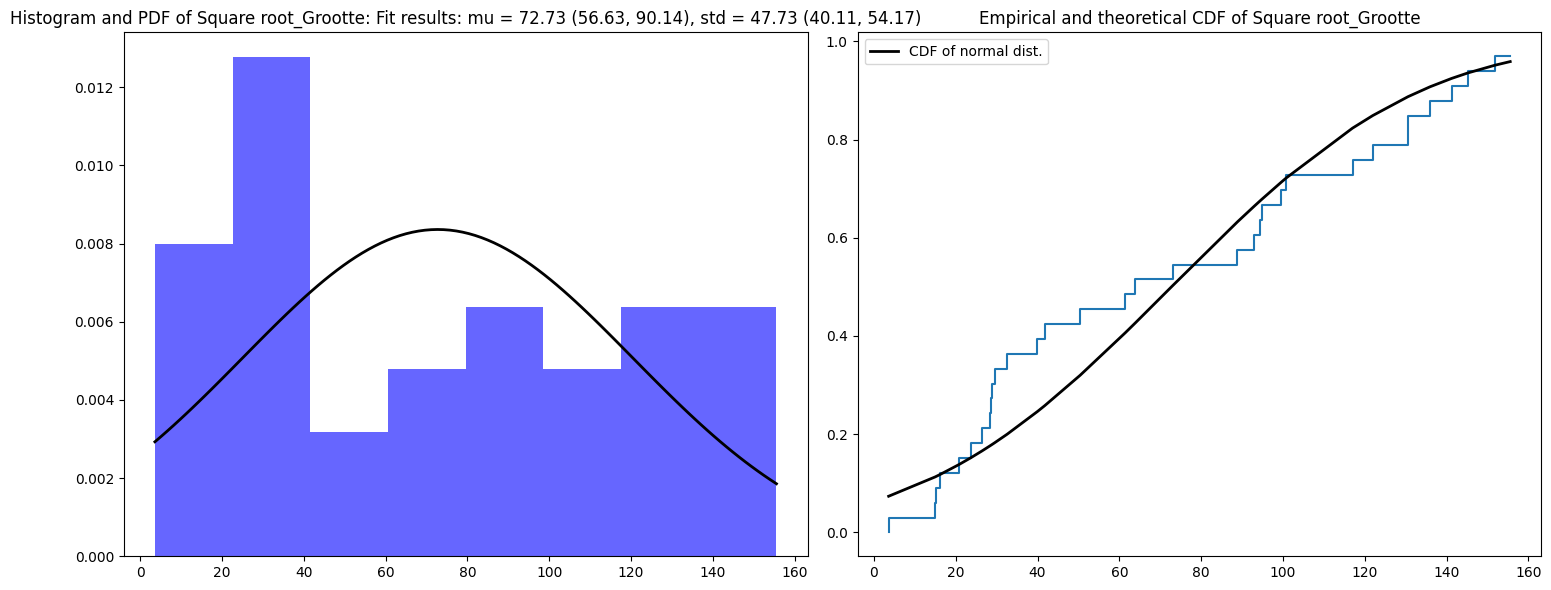

In [32]:
from scipy.stats import norm, sem
from sklearn.utils import resample

def bootstrap_CI(data, n_iterations=1000):
    """Returns 95% Confidence Interval using bootstrapping method"""
    means = np.array([resample(data).mean() for _ in range(n_iterations)])
    stds = np.array([resample(data).std() for _ in range(n_iterations)])

    CI_means = np.percentile(means, [2.5, 97.5])
    CI_stds = np.percentile(stds, [2.5, 97.5])

    return CI_means, CI_stds

def plot_histogram_and_ecdf(df, col, bins=8):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Histogram
    data = df[col].dropna()
    n, bins, patches = ax1.hist(data, bins=bins, density=True, alpha=0.6, color='b')

    # Estimate parameters of normal distribution
    mu, std = norm.fit(data)

    # Compute Confidence Intervals using bootstrapping
    CI_mu, CI_std = bootstrap_CI(data)

    # Plot the PDF.
    xmin, xmax = min(data), max(data)
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax1.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f (%.2f, %.2f), std = %.2f (%.2f, %.2f)" % (mu, CI_mu[0], CI_mu[1], std, CI_std[0], CI_std[1])
    ax1.set_title(f'Histogram and PDF of {col}: {title}')

    # ECDF
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data))/float(len(sorted_data))
    ax2.step(sorted_data, yvals)

    # Plot normal distribution CDF
    norm_cdf = norm.cdf(sorted_data, mu, std)
    ax2.plot(sorted_data, norm_cdf, 'k', linewidth=2, label='CDF of normal dist.')
    ax2.set_title(f'Empirical and theoretical CDF of {col}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    
# You can then call this function for each column
cols = ['Volume', 'Grootte'] + [f'{name}_{col}' for name in transformations for col in ['Volume', 'Grootte']]

for col in cols:
    plot_histogram_and_ecdf(df, col)


In [34]:
# Define 'large_acorn'
df['large_acorn'] = df['Volume'] >= 3

# Create contingency table
contingency_table = pd.crosstab(df['Regio'], df['large_acorn'])
print(contingency_table)

large_acorn  False  True 
Regio                    
Atlantic        17      6
California       5      5


In [38]:
from scipy.stats import chi2_contingency

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p)

Chi-square statistic: 0.878804347826087
p-value: 0.3485293680989825
